In [1]:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing  

import math              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cmath 
from sympy import symbols, I, exp, diff, lambdify


# Computing the Intensity Profile of a Yagi Uda Antenna

In [6]:
"All lengths given in units of the wavelength lambda"
l_1 =  [0.6, 0.5, 0.45, 0.45, 0.45] #antenna lengths. 
l_2 =[0.001, 0.001, 0.001, 0.001, 0.001] #antenna radii
l_3 = [(0,0), (0.5,0), (1,0), (1.5,0), (2,0)] #antenna position

V = [0, 1, 0, 0, 0] #voltage in each antenna

def G_new(p, q, k, z, z_1, L_1, L_2, L_3):
   
    """

    Parameters
    ----------
    p, q: antenna indexes
    k : wavenumber
    z : 
    z_1 : z'
    L_1, L_2, L_3: list of antennas characteristic (ordered in the same order as the antennas in the linear array)
    Returns so called impedance kernel=Green function, used to compute the impedance coefficients
    -------
    """

    #print(L_2)
    if p == q:
        d = L_2[p]
    else:
        d = math.sqrt((L_3[p][0] - L_3[q][0])**2+ (L_3[p][1] - L_3[q][1])**2)
    #print(d)
    R = math.sqrt((z - z_1)**2 + d**2)
    if R < 1e-6:  # threshold for small distances
        return 0 
    #print(R)
    return (cmath.exp(-k * R*1j))/R


def Z_new(p, q, k=1):
    """
    Compute the coefficient of entry (p, q) of the impedance matrix (after integration by part). 
    In fact, no need to put k as argument.
    Note: The same formula can be retrieved with the near-field expression
    p, q: index of coeff Zpq in the impedance matrix

    """
    global l_1, l_2, l_3
    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l_1]
    L_2 = [l*wavelength for l in l_2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l_3]
    h_p = L_1[p]/2
    h_q = L_1[q]/2
    if p == q:
        N = 500 
    else:
        N = 300
    Z = 0
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    
    for n in range(-N//2, N//2+1):
        z_1 = (n*2*h_q)/N
        dz_1 = 2*h_q/N
        g1 = G_new(p, q, k, h_p, z_1, L_1, L_2, L_3)
        g2 = G_new(p, q, k, -h_p, z_1, L_1, L_2, L_3)
        g3 = G_new(p, q, k, 0, z_1, L_1, L_2, L_3)
        sinq = math.sin(k*(h_q- abs(z_1)))
        Z += sinq*(g1+g2-2*np.cos(k*h_p)*g3)*dz_1
    Z = Z*(complex(0, eta/(4*math.pi)))*1/(np.sin(k*h_p)*np.sin(k*h_q))          
    return Z   

In [7]:
def matrixZ_new(k):
    """
    Compute the impedance matrix Z for antenna arrays
    
    """
    n = len(l_1) #nb of antennas
    #matZ = np.matrix([[Z(p,q,k) for q in range(0,n)] for p in range(0,n)])
    matZ= np.zeros((n, n), dtype=complex)
    for p in range(0, n):
        for q in range(0, p+1):
            Z_pq =  Z_new(p,q,k)
            if p == q:
                matZ[p][q] = Z_pq
            else:
                matZ[p][q] = Z_pq
                matZ[q][p] = Z_pq
    return matZ

In [8]:
matrixZ_new(1)

array([[132.36384086+255.61023395j, -17.32401062 -39.89645606j,
          4.87386307 +20.67505743j,  -2.31176679 -14.39613386j,
          1.33226521 +10.97434186j],
       [-17.32401062 -39.89645606j,  73.07234101 +42.10172239j,
        -10.67083357 -25.86672456j,   3.34582537 +15.22053164j,
         -1.56505923 -10.52793085j],
       [  4.87386307 +20.67505743j, -10.67083357 -25.86672456j,
         54.28690836 -51.13835024j,  -9.0910732  -22.38294374j,
          2.78912156 +13.06710927j],
       [ -2.31176679 -14.39613386j,   3.34582537 +15.22053164j,
         -9.0910732  -22.38294374j,  54.28690836 -51.13835024j,
         -9.0910732  -22.38294374j],
       [  1.33226521 +10.97434186j,  -1.56505923 -10.52793085j,
          2.78912156 +13.06710927j,  -9.0910732  -22.38294374j,
         54.28690836 -51.13835024j]])

In [23]:
def input_current(V,Z):
    I = np.linalg.solve(Z, V)
    return I  

In [24]:
V = [0, 1]+[0]*(len(l_1)-2) #=[0, 1, 0, 0, 0] for 5 elements

In [25]:
def radiation_U_2(k, l_1, l_2, l_3):
    """
    radiation intensity for the SPECIFIC case of antenna arrays along x-axis, which needs to be refined for other types.
    k: wavenumber of the emitted wave
    careful at theta = 0, theta = pi
    """

    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l_1]
    L_2 = [l*wavelength for l in l_2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l_3]
    
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    #theta = np.pi/2
    M = 400
    theta = np.linspace(0, np.pi, M)
    #phi = np.linspace(0, 2*np.pi, 500) #for 3D plot
    phi = 0 #np.pi #choose expected direction of propagation for 2D plot
    I = input_current(V,matrixZ_new(k))
    U = np.zeros_like(theta, dtype=complex)  # to accumulate field
    for p in range(0, len(L_1)):
        h_p = L_1[p]/2
        mask = (theta != 0) & (theta != np.pi) #to deal with division by 0 at theta = 0 and theta = pi
        term1 = np.exp(1j*k*np.sin(theta)*L_3[p][0]*np.cos(phi))
        term2 = np.zeros_like(theta)
        term2[mask] = (np.cos(k*h_p*np.cos(theta[mask]))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta[mask]))
        U += I[p]*term1*term2
    U= (eta/(8*np.pi**2))*abs(U)**2
   
    
    return U,theta

# Investigating the Beam Width of a Yagi Uda Configuration

In [40]:
def beam_width_phi0(k, l1, l2, l3):
    # Compute radiation intensity and theta values once
    U, theta = radiation_U_2(k, l1, l2, l3)

    # Half-power threshold
    U_half = np.max(U) / 2
    deltaU = U - U_half

    indices = []
    i = 0
    while i < len(deltaU) - 1:
        # Falling edge: U > U_half to U < U_half
        while i < len(deltaU) - 1 and deltaU[i] > 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

        # Rising edge: U < U_half to U > U_half
        while i < len(deltaU) - 1 and deltaU[i] < 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

    # Final filter: remove any crossings where theta ≈ π (e.g. > π - 0.01)
    indices = [idx for idx in indices if theta[idx] < np.pi - 1e-2]


    if len(indices) < 2:
        print("Could not find enough valid half-power points.")
        return None
    
    # Plotting
    #plt.plot(theta, U, label='U(θ)')
    #plt.axhline(y=U_half, color='r', linestyle='--', label='Half Power')
    #for idx in indices:
        #plt.axvline(x=theta[idx], color='g', linestyle='--')
    #plt.xlabel("θ (radians)")
    #plt.ylabel("Radiation Intensity U(θ)")
    #plt.title("Radiation Pattern at φ = 0")
    #plt.grid(True)
    #plt.legend()
    #plt.show()

    # Beamwidth across all valid lobes
    return abs(theta[indices[-1]] - theta[indices[0]])

In [41]:
beam_width_phi0(2*np.pi,l_1,l_2,l_3)

0.7873665798470659

In [42]:
def seperation_beamwidth_relation(k, l1, l2):
    # Generate separations from 0.1 to 1.0
    sep = np.linspace(0.1, 5.0, 500)

    # Create array of element positions for each separation
    configs = [[(i * dist, 0) for i in range(5)] for dist in sep]

    # Calculate beamwidths
    beam_widths = np.array([
        beam_width_phi0(k, l1, l2, config) for config in configs
    ])

    # Find the separation that gives the minimum beamwidth
    min_index = np.nanargmin(beam_widths)
    min_sep = sep[min_index]
    min_beamwidth = beam_widths[min_index]

    # Plot
    plt.plot(sep, beam_widths, label='Beamwidth vs Separation')
    plt.axvline(x=min_sep, color='r', linestyle='--', label=f'Min @ {min_sep:.3f}')
    plt.scatter([min_sep], [min_beamwidth], color='red')  # highlight min point
    plt.xlabel("Separation (λ)")
    plt.ylabel("Beamwidth (radians)")
    plt.title("Relation Between Element Separation and Beamwidth")
    plt.grid(True)
    plt.legend()
    plt.show()

    return min_sep

### Relating the Speration between Antennae to Beamwidth

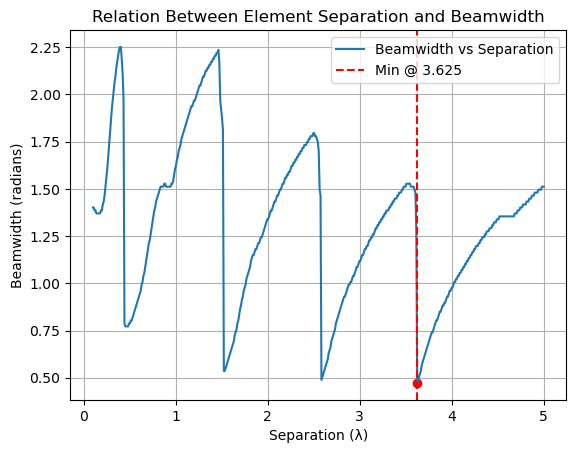

3.625250501002004

In [43]:
seperation_beamwidth_relation(3*np.pi,l_1,l_2)